In [3]:
import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker
from tic_env import TictactoeEnv, OptimalPlayer
from tensorflow.keras import layers
import tensorflow.keras as keras
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras import backend as K

%matplotlib inline

ModuleNotFoundError: No module named 'libtensorflow'

In [3]:
class Agent(OptimalPlayer):

  def __init__(self):
    self.model = self.create_model()
    self.target_model =  self.create_model()

  def create_model(self):
    model = Sequential()
    # model.add(Flatten(input_shape=[3,3,2]))
    model.add(Conv2D(8, kernel_size=(1, 1),
                 activation='relu',
                 input_shape=[3,3,2],
                 strides=(1,1), padding='same'))
    
    model.add(Conv2D(8, (3, 3), activation='relu',padding='same'))
    model.add(Flatten())
    """
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(9, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    """
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(9, activation='linear'))
    model.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0005,

)
)
    
    return model

  def show_heat_map(self, pred):
    data = np.reshape(pred, [3,3])
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=plt.get_cmap('hot'), interpolation='nearest',
              vmin=0, vmax=1)
    fig.colorbar(im)
    plt.show()

  def act(self, env, agent_player, show=False, valid_move = False):
    model_input = np.zeros([1,3,3,2])
    model_input[0,:,:,0] = env==agent_player
    model_input[0,:,:,1] = env==(-1)*agent_player
    #print(model_input)
    #print(model_input.shape)
    pred = np.squeeze(self.target_model(model_input).numpy())
    #print(np.array(pred).shape)
    if valid_move:
      # zero out anywhere where there is already a player
      pred[env.flatten() != 0] = 0

    if show:
      self.show_heat_map(pred)
    #print(pred.argmax())

    return int(pred.argmax()), pred

In [4]:
from copy import deepcopy
from sklearn.preprocessing import normalize
def render_all(things, vmin=0, vmax=2, cmap='cool', show_max=True):
  display_all = np.zeros([3,3*(len(things))])
  for i, thing in enumerate(things):
    if show_max:
      print('make move: ', thing.argmax())
    step = 3*i
    display_all[:,step:step+3] = np.reshape(thing, [3,3])
  plt.imshow(display_all, vmin=vmin, vmax=vmax, cmap=cmap)
  plt.show()

def apply_rewards(reward, predictions, decay = 0.99):
  # copy and reverse (more reward applied to latest moves)
  output = deepcopy(predictions)[::-1]
  #print(output)
  #print(np.array(output).shape)
  applied_reward = reward
  for pred, move in output:
    move_index =  np.unravel_index(move, pred.shape)
    pred[ move_index ] = np.clip(pred[ move_index ] + applied_reward, 0, 1)
    applied_reward *= decay
  # un-reverse 
  return [o[0] for o in output[::-1]]

def get_states(memory):
  return [m[0] for m in memory]

def get_new_qs(memory):
  return [m[1] for m in memory]

def render_memory(memory):
  states = get_states(memory)
  updated = get_new_qs(memory)
  current = [m[2][0] for m in memory]
  print('states')
  render_all(states)
  print('current qs')
  render_all(current)
  print('upated qs')
  render_all(updated)

In [6]:
random.seed(4)

env = TictactoeEnv()
Turns = np.array(['X','O'])
agent = Agent()
epsilon =0.1
memory =[]
all_rewards=list()
all_loss = list()
for i in range( 20000):

      #update network
    bad_move=False
    env.reset()
    history = []
    predictions = []
    grid, _, __ = env.observe()
    Turns = [Turns[i%2], Turns[(i%2+1)%2]]
    #agent.new_game()
    agent.player = Turns[0]
    player_opt_2 = OptimalPlayer(epsilon=0.5, player=Turns[1])
    agent_player = env.player2value[agent.player]
    for j in range(9):
        if env.current_player == agent.player:
            move, pred = agent.act(grid, agent_player)            
            if random.random() < epsilon:
              move= agent.randomMove(grid)
              move = move[0]*3 + move[1]
            predictions.append([pred, move])
        else:
            move = player_opt_2.act(grid)
        try:
          grid, end, winner = env.step(move, print_grid=False)
          history.append([grid.copy(), move])
        except ValueError:
          if env.current_player == agent.player:
            #print("agent played used field")
            end = True
            winner = player_opt_2.player
            bad_move = True
        if end:
            """
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Agent player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            """
            reward_value =env.reward(agent.player)
            all_rewards.append(reward_value)
            #train_loss = agent.model.history.history
            #print(train_loss)
            updated_q = apply_rewards(reward_value, predictions, decay=0.99 if not bad_move else 0)
            states = [h[0] for h in history]

            for j in range(len(updated_q)):
              memory.append( [states[j], updated_q[j], predictions[j]])
            #env.render()
            env.reset()
            break;
            
    memory = memory[-10000:] if len(memory)>10000 else memory
    #print(np.shape(memory))
    #print(np.shape(memory[-20:]))
    
    X, y, hist = update_network(memory, agent_player)
    all_loss.append(np.mean(hist[0].history['loss']))
    if i%500==0:
      print(i)
      agent.target_model.set_weights(agent.model.get_weights())
    #print(agent.model.history.history['loss'])


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500


In [5]:
def update_network(memory, agent_player):
  _X = np.array(get_states(memory))
  X = np.zeros([*_X.shape,2])
  # swap values
  X[:,:,:,0] = (_X == agent_player)
  X[:,:,:,1] = (_X == (-1)*agent_player)
  y = np.squeeze(np.array(get_new_qs(memory)))
  hist = agent.model.fit(X, y, epochs=1, verbose=0, batch_size=64), #sample_weight=weights)
  return X, y, hist

In [9]:
agent.target_model.set_weights(agent.model.get_weights())
#save the model ?
agent.target_model.save('winer.keras')
agent.target_model.save_weights('winer_weights.keras')

In [ ]:
moves = [p[2][0] for p in memory]
moves_np = np.squeeze(np.array(moves).sum(axis=1))
moves_np.shape


_X = np.array(get_states(memory))
X = np.zeros([*_X.shape,2])
X[:,:,:,0] = (_X == 1)
X[:,:,:,1] = (_X == -1)
y = np.squeeze(np.array(get_new_qs(memory)))

y_sum = y.sum(axis=1)

pos = (y_sum > moves_np)

positive_rewards = pos.sum()
negative_rewards = (~pos).sum()
print('{} positive change, {} negative change'.format(positive_rewards ,
                                                      negative_rewards))


pos_weight =  negative_rewards/len(y)
neg_weight =  positive_rewards/len(y)

weights = np.zeros(len(y))
weights[pos] =  0.05 #pos_weight
weights[~pos] = 0.9 # neg_weight
pos_weight,neg_weight

3 positive change, 459 negative change


(0.9935064935064936, 0.006493506493506494)

In [ ]:
hist = agent.model.fit(X, y, epochs=100, verbose=0, batch_size=32), #sample_weight=weights)


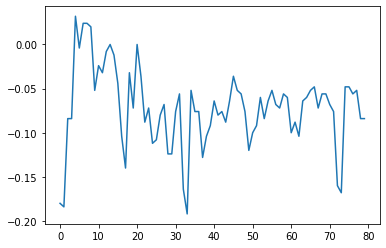

In [7]:
print(hist[0])
mean_loss = list()
mean_reward = list()
for i in range(0,len(all_loss), 250):
  #print(i)
  mean_loss.append(np.mean(all_loss[i:i+250]))
  mean_reward.append(np.mean(all_rewards[i:i+250]))

plt.plot(mean_reward[:])


20000


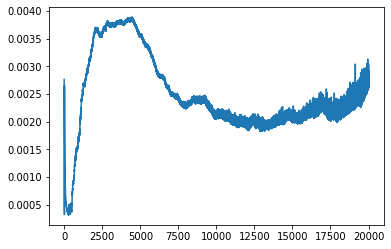

In [8]:
plt.plot(all_loss[:])
print(len(all_loss))

In [ ]:
_X = np.array(get_states(memory))
X = np.zeros([*_X.shape,2])
X[:,:,:,0] = (_X == 1)
X[:,:,:,1] = (_X == -1)
print(X)

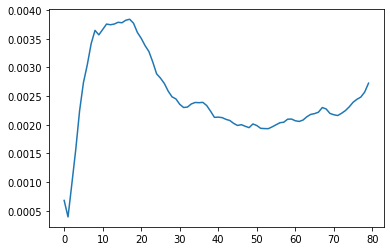

In [9]:
plt.plot(mean_loss[:])